In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path
from dotenv import load_dotenv

from src.metrics import pearson_metric
from src.feature_engineering import features_pca

load_dotenv()

True

In [2]:
dataset_dir = Path(os.environ['dataset_dir'])
full_data = pd.read_csv(dataset_dir / 'train.csv')
sample_data = pd.read_csv(dataset_dir / 'train_sample.csv', index_col=0)

In [3]:
data = full_data

In [4]:
data = data.set_index('row_id')

In [5]:
# train on earlier data, test on later data
train = data[data.time_id < 1000]
val = data.query("1000 <= time_id < 1100")
test = data.query("1000 <= time_id")

x_train, y_train = train.drop('target', axis=1), train[['time_id', 'target']]
x_val, y_val = val.drop('target', axis=1), val[['time_id', 'target']]
x_test, y_test = test.drop('target', axis=1), test[['time_id', 'target']]

In [6]:
x_train_pca, x_test_pca = features_pca([x_train, x_test], n_components=100)

In [9]:
from catboost import CatBoostRegressor, Pool
def evaluate_model(x_train, x_test, y_train, y_test):
    train_pool = Pool(x_train.drop('time_id', axis=1), y_train.target, cat_features=['investment_id'])

    model = CatBoostRegressor(
        iterations=1000,
        random_state=0,
        cat_features=['investment_id'], 
        verbose=200,
        task_type='GPU',
        devices='0:2',
        grow_policy='SymmetricTree',
        bootstrap_type="Bernoulli",
        max_depth=3,
    )
    model = model.fit(train_pool)
    
    test_pool = Pool(x_test, cat_features=['investment_id'])
    y_pred = model.predict(test_pool)
    y_pred = pd.DataFrame({'target': y_pred}, index=x_test.index)
    rmse = np.mean(np.sqrt((y_pred.target - y_test.target) ** 2))
    return rmse, pearson_metric(y_test, y_pred), model
    

In [10]:
rmse, pearson, model = evaluate_model(
    x_train_pca, 
    x_test_pca, 
    y_train, 
    y_test
)
print(f"RMSE: {rmse}, Pearson: {pearson}")

Learning rate set to 0.112177
0:	learn: 0.9235739	total: 21.8ms	remaining: 21.8s
200:	learn: 0.9162756	total: 4.42s	remaining: 17.6s
400:	learn: 0.9148667	total: 8.61s	remaining: 12.9s
600:	learn: 0.9138864	total: 12.9s	remaining: 8.57s
800:	learn: 0.9131240	total: 17.2s	remaining: 4.28s
999:	learn: 0.9124554	total: 21.4s	remaining: 0us
RMSE: 0.6000801320807011, Pearson: 0.12362273650573671


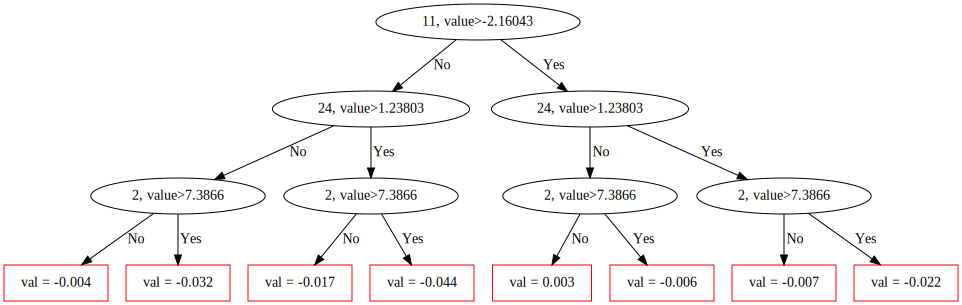

In [11]:
model.plot_tree(0)

In [ ]:
# weights_dir = dataset_dir / 'weights'
# os.makedirs(weights_dir, exist_ok=True)
# model.save_model(weights_dir / 'w1.cbm')